## CS421 PROJECT

### Data and Task

In this project, you will be working with data extracted from a recommender systems type dataset: you are provided with a large set of interactions between subjects (e.g., online shopping users, or social network users)  and items (e.g., shopping items, books, songs, or movies). Whenever a user "interacts" with an item, he/she has some experience the item (e.g., purchase the items, read the book, listen the songs, or watch the movie) and gives a mark or "rating" between 0 and 5 stars (5 stars indicating the best experience, and 1 or 0 stars indicating that the user didn't like the experience at all). 




In this exercise, we will **not** be performing the recommendation task per se. Instead, we will identify *anomalous users*. In the dataset that you are provided with, some of the data was corrupted. Whilst most of the data comes from real life user-item interactions from a real-world application, some "users" are anomalous: they were generated by me according to some undisclosed procedure to simulate exceptional users with unexpected interactions. Most users have normal, expected interactions in real applications, so the anomalous users only account for a very small proportion of the users. Thus, identifying those anomalous users are important to the application, but it can be very challenging.

You are provided with two data frames: the first one ("ratings") contains the interactions provided to you, and the second one ("labels") contains the labels for the users. There is a set of 1,200 unique items the users interact with, ranging from item ID of 0 to item ID 1199, which is fixed throughout the competition. Note that it is not necessarily that all items appear in one set of data samples given during the competition, meaning that some of the items may not be rated by any user in a user set within a specific period of time.

As you can see, the three columns in "ratings" correspond to the user ID, the item ID and the rating. Thus, each row of "ratings" contains a single interaction. For instance, if the row "142, 152, 5" is present, this means that the user with ID 142 has given the movie 152 the rating 5 stars.

The dataframe "labels" has two columns. In the first column we have the user ids, whilst the second column contains the labels. A label of 1 indicates that the user is 'anomalous', whilst a label of 0 denotes a natural, normal user (coming from real life interactions). 

For instance, if the labels matrix contains the line "142, 1", it means that all of the ratings given by the user with id 142 is an anomalous user. This means all lines in the dataframe "ratings" which start with the userID 142 correspond to fake interactions. 

### Evaluation

Your task is to be able to classify unseen instances as either anomalies or non anomalies. 

There are **far more** normal users than anomalies in the dataset, which makes this a very heavily **unbalanced dataset**. Thus, accuracy will not be a good measure of performance, since simply predicting that every user is normal will give good accuracy. Thus, we need to use some other evaluation metrics (see lecture notes from week 3). 

Suitable **EVALUATION METRICS** include: **AUC** (AREA UNDER CURVE), **PRECISION**, **RECALL**, and **F1 score**. The **main metric** will be the **AREA UNDER CURVE**, and it will by default be used to rank teams. This means your programs should return an **anomaly score** for each user (the higher the score, the more likely the model think the sample is anomalous).  

Before Week 9, each team is required to develop a model using the data "training_data_with_labels.npz" that contains labeled data. You can leverage the data in whatever the way you believe is right. Thereafter every week, we will evaluate the performance of each team's model on an *unseen test set* I will provide, in terms of AUC, and rank the teams by **AUC**. We will release the class labels for the test dataset after we finalize the ranking for each week. Each team then can utilize this newly released class labels (together with the previously released labeled data) to develop a better model.

The difficulty implied by **the generation procedure of the anomalies WILL CHANGE as the project evolves: depending on how well the teams are doing, I will generate easier or harder anomalies**.

The **first round of competition** will take place after recess (week 9): this means that I will **release the first test set on the Tuesday of week 9**, and you must submit at least one valid set of anomaly scores to **CodaLab** before the **Monday of week 10 at 11:59 PM**. Your submission will be **a csv file** with only one column, containing the scores for the users I will send you for each test set. You should NOT include the index and header names into the csv file. We will then look at the results together during Tuesday's class. Each group will be limited to no more than **THREE submissions per week**. The best result is taken to rank in the leaderboard.  

We will check everyone's performance in this way every week (once on  week 10, once on week 11, and once on week 12). 

Whilst performance (expressed in terms of AUC and your ranking compared to other teams) at **each of the check points** (weeks 9 to 12 inclusive) is an **important component** of your **final grade**, the **project report** and the detail of the various methods you will have tried will **also** be very **important**. Ideally, to get perfect marks (A+) for this component, you should try at least **two supervised methods** and **one unsupervised methods**, as well as be ranked the **best team** in terms of performance.

The performance part of the grading will be based the leaderboard ranking of your group averaged over the three weeks (50% on the first two rounds of ranking, and 50% on the last round of ranking).

In [649]:
import numpy as np
import pandas as pd
data=np.load("week_9_data/training_data_with_labels.npz")
data_new = np.load("week_10_data/first_batch_test_with_labels.npz")
data_new_2 = np.load("week_11_data/second_batch_test_with_labels.npz")

X_existing = data["X"]
y_existing = data["y"]
X_existing[:, 0] = X_existing[:, 0] - 100
y_existing[:, 0] = y_existing[:, 0] - 100

X_new = data_new["X"]
y_new = data_new["y"]
X_new_2 = data_new_2["X"]
y_new_2 = data_new_2["y"]

In [650]:
X = np.concatenate((X_existing, X_new, X_new_2), axis=0)
y = np.concatenate((y_existing, y_new, y_new_2), axis=0)

print("# of interactions:", X.shape[0])
print("# of anomalous and normal users:", np.count_nonzero(y==1), np.count_nonzero(y==0))

XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
print("# of items:", XX['item'].unique().shape[0])

# of interactions: 608091
# of anomalous and normal users: 321 3101
# of items: 1199


In [651]:
yy.rename(columns={0:"user",1:"label"},inplace=True)
yy.head()

,user,label
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


In [652]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.utils import class_weight
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [653]:
merged_data = pd.merge(XX, yy, on='user', how='left')
merged_data.head()

,user,item,rating,label
0,99,0,3,0
1,99,4,5,0
2,99,7,4,0
3,99,12,4,0
4,99,13,5,0


In [654]:
len(merged_data["user"].unique())

3420

In [655]:
groups_X = merged_data.groupby('user')
groups_X = [group for _, group in groups_X]

In [656]:
new_data = merged_data[['item']] 
 
values = new_data['item'].value_counts(normalize=True, dropna=False).keys().tolist() 
counts = new_data['item'].value_counts(normalize=True, dropna=False).tolist() 
popularity_index = dict(zip(values, counts))

item_counts = merged_data[['item','label']].groupby('item').value_counts(normalize=True) 
 
plotting_table = item_counts.unstack(level=1) 
 
plotting_table = plotting_table.reset_index() 
 
plotting_table = plotting_table.fillna(0) 
 
anomalous_items = np.array(plotting_table[plotting_table[1]>=0.5]['item'])

max_rating_global = merged_data['rating'].max()
min_rating_global = merged_data['rating'].min()
avg_rating_global = merged_data['rating'].mean()

In [773]:
item_groups = merged_data.groupby('item')
item_groups = [group for _, group in item_groups]

item_df = pd.DataFrame(columns=["item", "interactions"])

for item in range(len(item_groups)):
    #get number of interactions per item
    new_row = {"item": item, "interactions": len(item_groups[item])}
    item_df.loc[len(item_df.index)] = new_row

top_threshold = item_df["interactions"].quantile(0.9)
bottom_threshold = item_df["interactions"].quantile(0.15)
popular_items = list(item_df[item_df['interactions'] >= top_threshold].index)
unpopular_items = list(item_df[item_df['interactions'] <= bottom_threshold].index)

In [784]:
# Feature Engineering
features_list = []

for group in groups_X:
    user = group['user'].iloc[0]
    label = group['label'].iloc[0] 
    min_rating = group['rating'].min()
    max_rating = group['rating'].max()
    total_interactions = group.shape[0]
    fsti = total_interactions / merged_data['item'].nunique()
    fsmaxrti = (group['rating'] == max_rating_global).sum() / total_interactions
    fsminrti = (group['rating'] == min_rating_global).sum() / total_interactions
    # Count how many times each user rated items exactly at their max or min rating
    max_rating_count = (group['rating'] == max_rating).sum()
    min_rating_count = (group['rating'] == min_rating).sum()
    tolerance = 2.5
    fsarti = ((group['rating'] >= avg_rating_global - tolerance) & 
              (group['rating'] <= avg_rating_global + tolerance)).sum() / total_interactions
    rating_range = (group['rating'].max() - group['rating'].min())
    unique_items = group['item'].nunique()
    item_diversity = group['item'].nunique() / merged_data['item'].nunique()
    proportion_of_5_stars = (group['rating'] == 5).sum() / total_interactions
    proportion_of_1_star = (group['rating'] == 1).sum() / total_interactions
    average_rating = group['rating'].mean()
    high_low_rating_ratio = proportion_of_5_stars / (proportion_of_1_star + 0.01)
    has_anomalous_item = 0 
    for item in group['item']: 
        if item in anomalous_items: 
            has_anomalous_item+=1

    score = 0
    for item in group['item']:
        score = score + item

    popularity_score = 0 
 
    for item in group['item']: 
        if popularity_index.get(item): 
            popularity_score += popularity_index.get(item)

    rating_variance = group['rating'].var()
    extreme_ratings_ratio = ((group['rating'] == 1) | (group['rating'] == 5)).sum() / total_interactions


    has_popular_item = 0
    has_unpopular_item = 0
    for item in group['item']: 
        #if item in anomalous_items: 
            #has_anomalous_item+=1
        if item in popular_items:
            has_popular_item += 1
        if item in unpopular_items:
            has_unpopular_item += 1


    fspi = has_popular_item / len(popular_items)
    fspii = has_popular_item / len(group["item"])
    fsui = has_unpopular_item / len(unpopular_items)
    fsuii = has_unpopular_item / len(group["item"])

    features_list.append({
        'user': user,
        'label': label,
        'min_rating': min_rating,
        'fsti': fsti,
        'fsmaxrti': fsmaxrti,
        # 'fsminrti': fsminrti,
        # 'fsarti': fsarti,
        'total_interactions': total_interactions,
        "has_anomalous_item": has_anomalous_item,
        'score': score,
        'popularity_score': popularity_score,
        'rating_variance': rating_variance,
        'unique_items': unique_items,
        "fspi": fspi,
        "fspii": fspii,
        # "fsui": fsui,
        # "fsuii": fsuii,
    })


features_df = pd.DataFrame(features_list)
# min_rating_0 = features_df['min_rating'] == 0
# features_df['min_rating_0'] = min_rating_0.astype(int)
features_df.head()

,user,label,min_rating,fsti,fsmaxrti,total_interactions,has_anomalous_item,score,popularity_score,rating_variance,unique_items,fspi,fspii
0,0,1,1,0.073394,0.079545,88,1,39401,0.144835,0.977926,88,0.250000,0.340909
1,1,0,0,0.302752,0.049587,363,0,149754,0.487970,2.168820,363,0.791667,0.261708
2,2,0,2,0.043369,0.480769,52,0,5189,0.094272,0.710407,52,0.183333,0.423077
3,3,0,2,0.144287,0.005780,173,0,120615,0.209635,0.321347,173,0.291667,0.202312
4,4,0,1,0.076731,0.402174,92,0,55434,0.142000,0.767678,92,0.233333,0.304348


In [785]:
# item_variance = merged_data.groupby('item')['rating'].var().reset_index(name='item_variance')
# merged_data_var = merged_data.merge(item_variance, on='item', how='left')

# user_avg_item_variance = merged_data_var.groupby('user')['item_variance'].mean().reset_index(name='avg_item_variance')

# Merge this new feature into features_df
# features_df = features_df.merge(user_avg_item_variance, on='user', how='left')

features_df.drop(columns=['user'], inplace=True)

In [786]:
# Q1 = features_df['total_interactions'].quantile(0.25)
# Q3 = features_df['total_interactions'].quantile(0.75)

# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# features_df = features_df[(features_df['total_interactions'] >= lower_bound) & 
#                           (features_df['total_interactions'] <= upper_bound)]

# features_df.head()

In [787]:
features_df['label'].value_counts()

label
0    3100
1     320
Name: count, dtype: int64

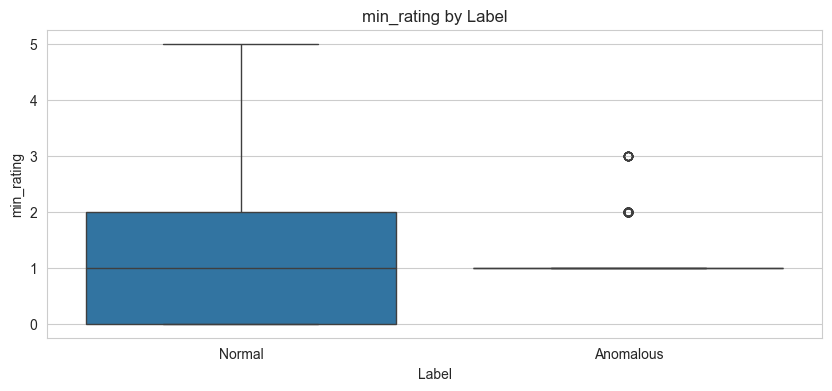

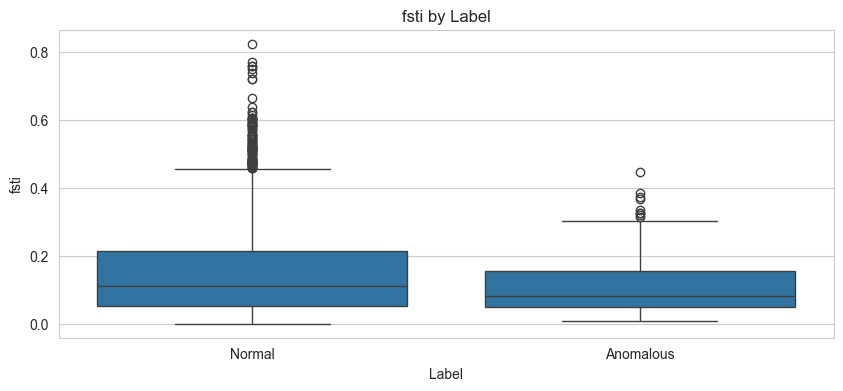

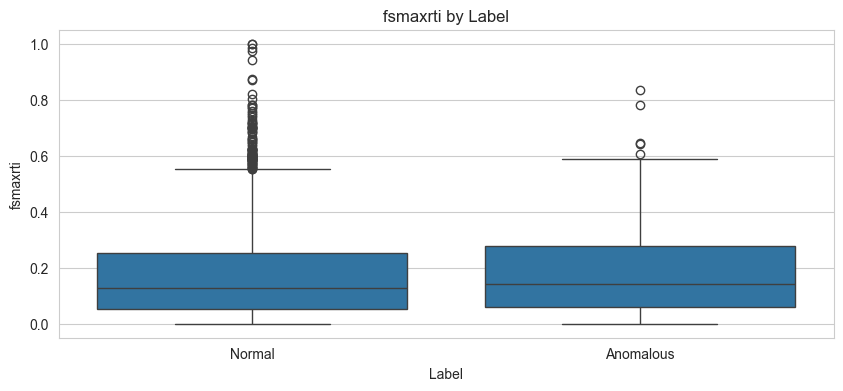

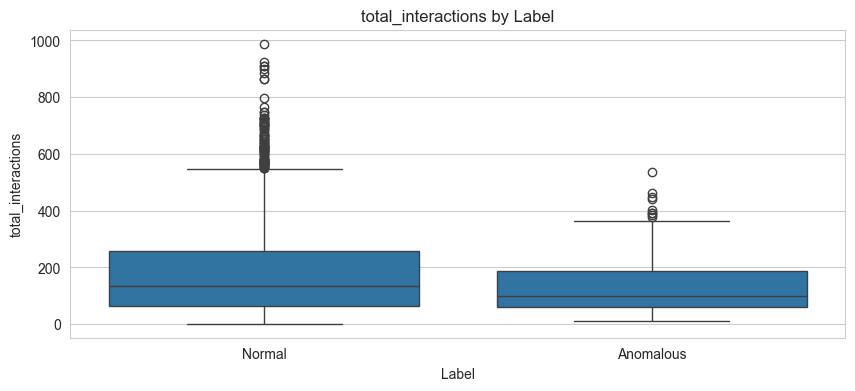

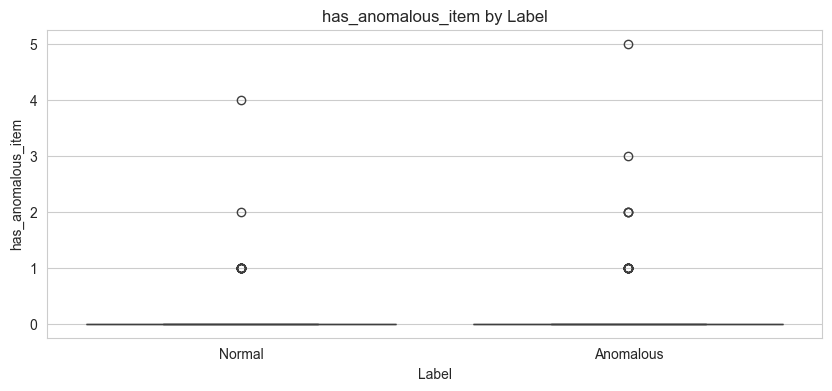

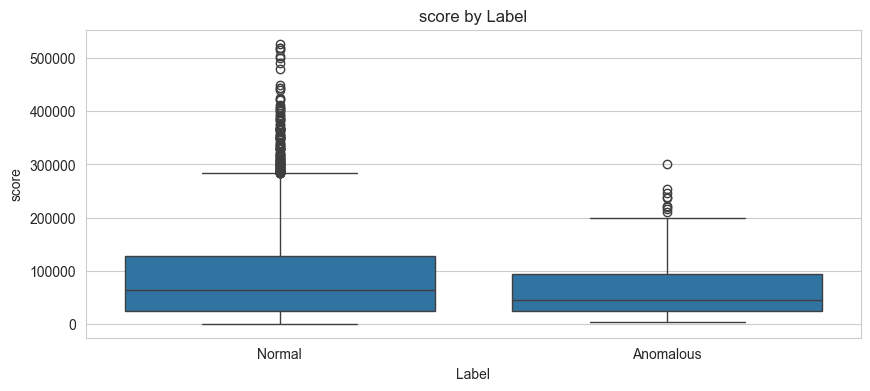

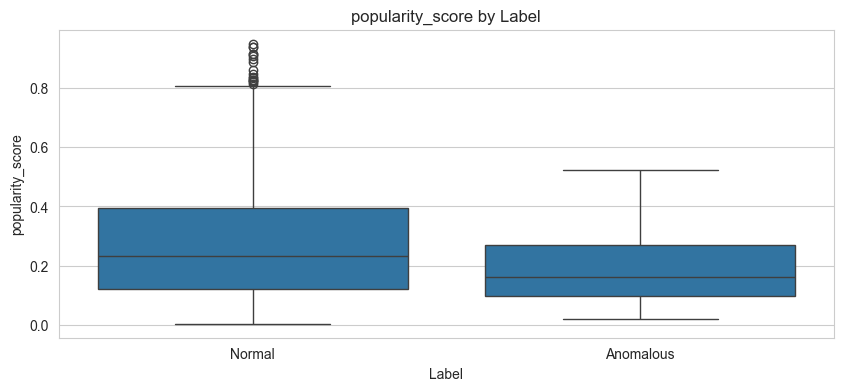

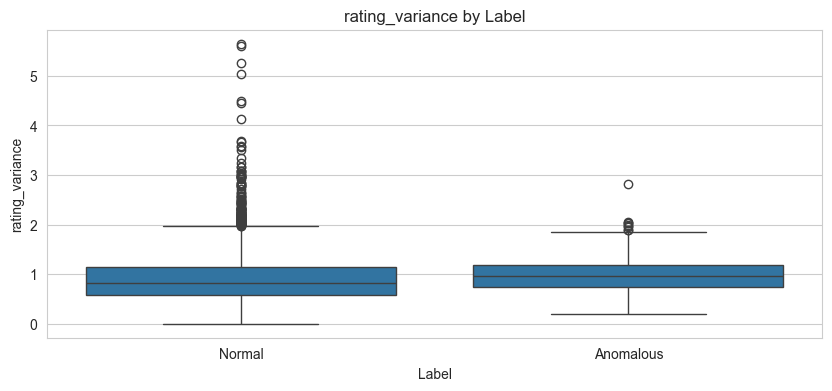

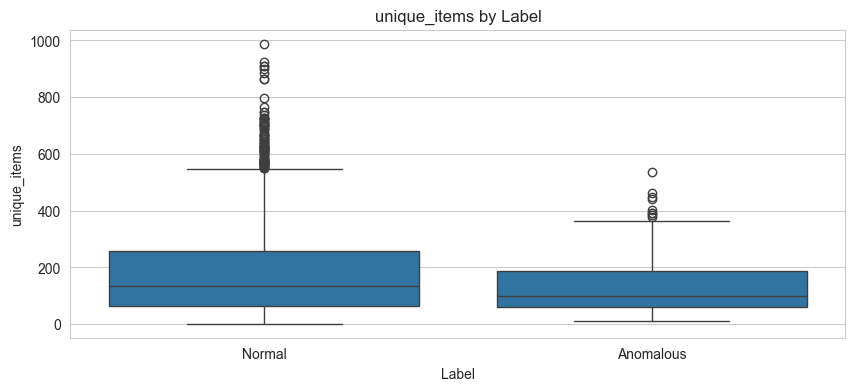

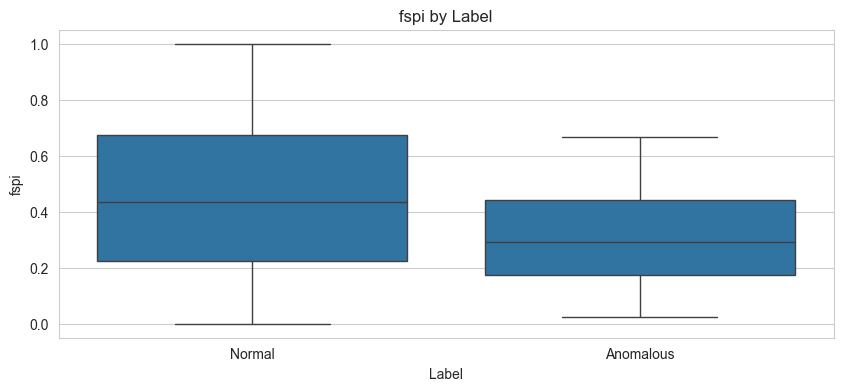

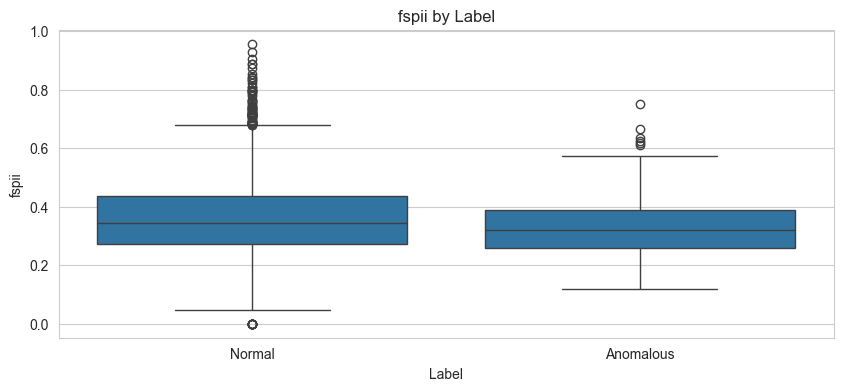

In [788]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot boxplots
for feature in features_df.columns[1:]:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
    plt.xlabel('Label')
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Normal', 'Anomalous'])
    plt.show()

In [789]:
def build_model(n_features, l2_value):
    model = Sequential()
    model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l2(l2_value), input_shape=(n_features,)))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='roc_auc', curve='ROC')])
    return model

In [790]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

X = features_df.drop(['label'], axis=1)
y = features_df['label']


X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Assuming features_df is your DataFrame and feature_columns are your columns of interest
scaler = StandardScaler()

X_main = scaler.fit_transform(X_main)
X_test = scaler.transform(X_test)

# X_main = pca.fit_transform(X_main)
# X_test = pca.transform(X_test)

X_main = pd.DataFrame(X_main)
X_main.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.128251,-0.782944,1.860977,-0.782944,-0.093137,-0.656968,-0.727673,-0.344065,-0.782944,-0.614788,1.532351
1,-0.028323,-0.735690,0.598790,-0.735690,-0.093137,-0.658736,-0.755135,-0.227150,-0.735690,-0.741418,0.624786
2,-1.184896,-0.796445,1.962050,-0.796445,-0.093137,-0.721437,-0.847120,0.386567,-0.796445,-0.836391,0.753271
3,-1.184896,1.383978,-0.304449,1.383978,-0.093137,0.827579,1.325732,0.370237,1.383978,1.347979,-0.858143
4,-0.028323,-0.796445,5.264959,-0.796445,-0.093137,-0.982257,-0.924105,-1.283793,-0.796445,-1.089651,-0.305757


In [791]:
# Define L1 values to test
l1_values = [0.001, 0.003, 0.005, 0.008]
best_l1 = l1_values[0]
best_auc = -np.inf

n_features = X_main.shape[1]

In [795]:
# for l1_value in l1_values:
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     auc_scores = []
    
#     for train_index, val_index in skf.split(X_main, y_main):
#         X_train, X_val = X_main.iloc[train_index], X_main.iloc[val_index]
#         y_train, y_val = y_main.iloc[train_index], y_main.iloc[val_index]
        
#         # Balance the training set
#         oversampler = SMOTE(random_state=42)
#         X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
        
#         # Build and fit the model
#         model = build_model(n_features, l1_value)
#         model.fit(X_resampled, y_resampled, batch_size=32, epochs=50, validation_data=(X_val, y_val),
#                   callbacks=[EarlyStopping(monitor="val_roc_auc", patience=5, mode='max', restore_best_weights=True)])
        
#         # Evaluate the model
#         y_pred = model.predict(X_val).ravel()
#         auc_score = roc_auc_score(y_val, y_pred)
#         auc_scores.append(auc_score)
    
#     average_auc = np.mean(auc_scores)
#     print(f"L1 value: {l1_value}, Average Validation AUC: {average_auc}")
    
#     if average_auc > best_auc:
#         best_auc = average_auc
#         best_l1 = l1_value

# print(f"Best L1 value: {best_l1}")
full_model = build_model(n_features, 0.003)

oversampler = SMOTE(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_main, y_main)

# Fit the model on the full training dataset
full_model.fit(X_main, y_main, batch_size=32, epochs=50, callbacks=[EarlyStopping(monitor="roc_auc", patience=5, mode='max', restore_best_weights=True)])

Epoch 1/50
86/86 [==============================] - 19s 140ms/step - loss: 0.6766 - roc_auc: 0.6756
Epoch 2/50
86/86 [==============================] - 4s 51ms/step - loss: 0.5058 - roc_auc: 0.7710
Epoch 3/50
86/86 [==============================] - 4s 47ms/step - loss: 0.3953 - roc_auc: 0.8094
Epoch 4/50
86/86 [==============================] - 4s 49ms/step - loss: 0.3330 - roc_auc: 0.8347
Epoch 5/50
86/86 [==============================] - 4s 48ms/step - loss: 0.2928 - roc_auc: 0.8568
Epoch 6/50
86/86 [==============================] - 4s 45ms/step - loss: 0.2780 - roc_auc: 0.8563
Epoch 7/50
86/86 [==============================] - 4s 45ms/step - loss: 0.2615 - roc_auc: 0.8727
Epoch 8/50
86/86 [==============================] - 4s 46ms/step - loss: 0.2495 - roc_auc: 0.8781
Epoch 9/50
86/86 [==============================] - 4s 45ms/step - loss: 0.2474 - roc_auc: 0.8796
Epoch 10/50
86/86 [==============================] - 4s 47ms/step - loss: 0.2277 - roc_auc: 0.9067
Epoch 11/50
86/86

In [796]:
full_model.evaluate(X_test, y_test)

22/22 [==============================] - 5s 171ms/step - loss: 0.1906 - roc_auc: 0.9217


[0.19056330621242523, 0.9217364192008972]

22/22 [==============================] - 1s 24ms/step
Best F1 Score: 0.5618 at Threshold: 0.2369


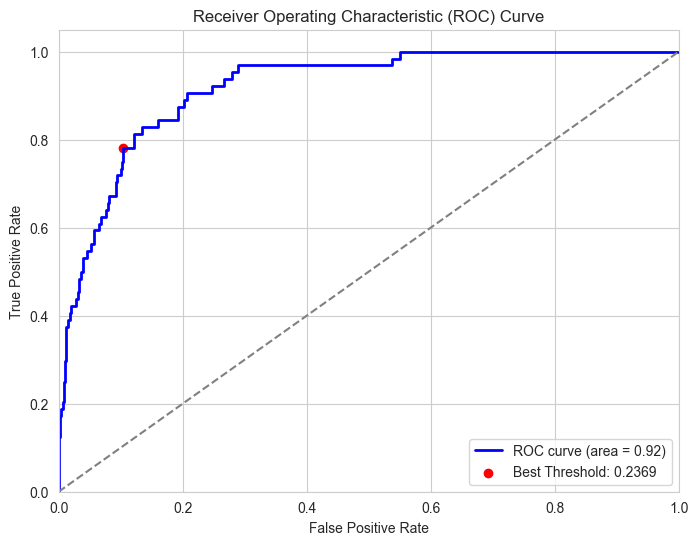

In [794]:
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt

y_pred_prob = full_model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Initialise variables to store the best F1 score and the corresponding best threshold
best_f1 = 0
best_threshold = 0.5
best_fpr = 0
best_tpr = 0

# Iterate over thresholds to find the best one for F1 score
for i, threshold in enumerate(thresholds):
    y_pred = (y_pred_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_fpr = fpr[i]
        best_tpr = tpr[i]

# Print the best F1 score and its corresponding threshold
print(f"Best F1 Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(best_fpr, best_tpr, color='red', label=f'Best Threshold: {best_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Test Set

In [669]:
data_2=np.load("week_11_data/third_batch_test.npz")

In [670]:
X=data_2["X"]
# y_trial_test=data_2["y"]

print("# of interactions:", X.shape[0])

XX_trial_test=pd.DataFrame(X)
# y_trial_test=pd.DataFrame(y_trial_test)
XX_trial_test.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
print("# of items:", XX['item'].unique().shape[0])

# of interactions: 349573
# of items: 1199


In [671]:
# y_trial_test.rename(columns={0:"user",1:"label"},inplace=True)
# y_trial_test.drop(columns=['user'], inplace=True)
# y_trial_test.info()

In [672]:
len(XX_trial_test['user'].unique())

2000

In [673]:
groups_X_test = XX_trial_test.groupby('user')
groups_X_test = [group for _, group in groups_X_test]

max_rating_global = XX_trial_test['rating'].max()
min_rating_global = XX_trial_test['rating'].min()
avg_rating_global = XX_trial_test['rating'].mean()

In [674]:
# Feature Engineering
test_features_list = []

for group in groups_X_test:
    user = group['user'].iloc[0]
    min_rating = group['rating'].min()
    max_rating = group['rating'].max()
    total_interactions = group.shape[0]
    fsti = total_interactions / XX_trial_test['item'].nunique()
    fsmaxrti = (group['rating'] == max_rating_global).sum() / total_interactions
    fsminrti = (group['rating'] == min_rating_global).sum() / total_interactions
    max_rating_count = (group['rating'] == max_rating).sum()
    min_rating_count = (group['rating'] == min_rating).sum()
    tolerance = 3  # Define tolerance for what you consider as 'average'
    fsarti = ((group['rating'] >= avg_rating_global - tolerance) & 
              (group['rating'] <= avg_rating_global + tolerance)).sum() / total_interactions
    rating_range = (group['rating'].max() - group['rating'].min())
    unique_items = group['item'].nunique()
    ratings_count = group['rating'].value_counts()
    item_diversity = group['item'].nunique() / merged_data['item'].nunique()
    proportion_of_5_stars = (group['rating'] == 5).sum() / total_interactions
    proportion_of_1_star = (group['rating'] == 1).sum() / total_interactions
    high_low_rating_ratio = proportion_of_5_stars / (proportion_of_1_star + 0.01)
    mode = group['rating'].mode()
    median_rating = group['rating'].median()
    average_rating = group['rating'].mean()
    test = min_rating *  unique_items
    

    score = 0
    for item in group['item']:
        score = score + item

    has_anomalous_item = 0 
    for item in group['item']: 
        if item in anomalous_items: 
            has_anomalous_item+=1

    popularity_score = 0 
 
    for item in group['item']: 
        if popularity_index.get(item): 
            popularity_score += popularity_index.get(item)

    rating_variance = group['rating'].var()
    extreme_ratings_ratio = ((group['rating'] == 1) | (group['rating'] == 5)).sum() / total_interactions

    has_popular_item = 0
    has_unpopular_item = 0
    for item in group['item']: 
        #if item in anomalous_items: 
            #has_anomalous_item+=1
        if item in popular_items:
            has_popular_item += 1
        if item in unpopular_items:
            has_unpopular_item += 1
    
    fspi = has_popular_item / len(popular_items)
    fspii = has_popular_item / len(group["item"])
    fsui = has_unpopular_item / len(unpopular_items)
    fsuii = has_unpopular_item / len(group["item"])

    test_features_list.append({
        'user': user,
        'min_rating': min_rating,
        'fsti': fsti,
        'fsmaxrti': fsmaxrti,
        # 'fsminrti': fsminrti,
        # 'fsarti': fsarti,
        'total_interactions': total_interactions,
        "has_anomalous_item": has_anomalous_item,
        'score': score,
        "popularity_score": popularity_score,
        'rating_variance': rating_variance,
        'unique_items': unique_items,
        "fspi": fspi,
        "fspii": fspii,
        "fsui": fsui,
        "fsuii": fsuii,
    })


# Create a DataFrame with the features
features_df_test = pd.DataFrame(test_features_list)
min_rating_0 = features_df_test['min_rating'] == 0
features_df_test['min_rating_0'] = min_rating_0.astype(int)

In [675]:
# item_variance = XX_trial_test.groupby('item')['rating'].var().reset_index(name='item_variance')
# XX_trial_test_var = XX_trial_test.merge(item_variance, on='item', how='left')

# user_avg_item_variance = XX_trial_test_var.groupby('user')['item_variance'].mean().reset_index(name='avg_item_variance')

# Merge this new feature into features_df
# features_df = features_df.merge(user_avg_item_variance, on='user', how='left')

features_df_test.drop(columns=['user'], inplace=True)

In [676]:
X_trial_test = features_df_test
X_trial_test = scaler.transform(X_trial_test)
# X_trial_test = pca.transform(X_trial_test)
X_trial_test = pd.DataFrame(X_trial_test)
X_trial_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.184896,-0.482952,-1.120666,-0.485920,-0.093137,-0.750662,-0.144211,-0.110560,-0.485920,0.493226,2.311555,-0.360287,-0.444032,1.561149
1,1.128251,-0.516846,0.763094,-0.519673,-0.093137,-0.758813,-0.211439,-0.090170,-0.519673,0.461568,2.490077,-0.360287,-0.444032,-0.640554
2,2.284825,-0.977805,-0.308700,-0.978709,-0.093137,-0.720129,-1.132158,-1.309270,-0.978709,-1.342911,-0.136147,-0.360287,-0.444032,-0.640554
3,-0.028323,-0.767662,-0.398919,-0.769443,-0.093137,-0.479451,-0.879213,-0.100389,-0.769443,-1.089651,-0.465452,-0.360287,-0.444032,-0.640554
4,-0.028323,0.303389,-0.532817,0.297142,-0.093137,0.291490,0.502878,-0.529652,0.297142,0.999746,0.183025,0.034801,0.129602,-0.640554


In [677]:
# full_model.evaluate(X_trial_test, y_trial_test)

In [678]:
y_trial_test_pred = full_model.predict(X_trial_test)

63/63 [==============================] - 1s 10ms/step


In [679]:
y_final_pred = y_trial_test_pred - best_threshold
y_final_pred

array([[-0.31667238],
       [-0.31549856],
       [-0.25974035],
       ...,
       [-0.30657932],
       [-0.17490971],
       [-0.31648892]], dtype=float32)

In [680]:
# indices_normal_users = features_df_test[(features_df_test['min_rating'] == 0) | (features_df_test['min_rating'] == 4) | (features_df_test['min_rating'] == 5)].index
# y_final_pred[indices_normal_users] = 0 - best_threshold

In [681]:
# fpr, tpr, thresholds = roc_curve(y_trial_test, y_final_pred)

# roc_auc = auc(fpr, tpr)

# roc_auc

In [682]:
answer = pd.DataFrame(y_final_pred)
answer.to_csv('weekly_prediction/week12.csv', index=False, header=False)

In [683]:
answer[answer[0]>=0].count()


0    162
dtype: int64

In [684]:
answer[answer[0]<0].count()

0    1838
dtype: int64